## Recommendation Engine with Collaborative Filtering

### Introduction

In this Recommendation Engine with collabarative filtering, I used cosine Similarity to find the similarity between the users.

This Reommendation Engine suggest services to users, and evaluate retention strategies.

`Class: RecommendationEngine`

This class encapsulates all logic for preprocessing data, building user profiles, recommending services, and analyzing retention.

**Attributes:**

- `user_profiles:` A DataFrame representing user characteristics and service usage.
- `similarity_matrix:` A matrix storing cosine similarity scores between users.
- `scaler:` An instance of StandardScaler for feature normalization.
- `features_encoded:` Encoded and preprocessed features excluding non-relevant columns.
- `service_columns:` List of columns representing service usage.

#### Methods:
`preprocess_data :` Prepares the dataset for analysis. Returns the preprocessed DataFrame.

`build_user_profiles :` Creates a similarity matrix based on user profiles.

`recommend_services :` Recommends services to users based on similarity scores.

`get_user_profile :` Finds users most similar to a given user. Returns the indices of similar users.

`analyze_retention_impact :` Analyzes the effect of service usage on customer retention.

## Overall Flow
1. Input raw data and preprocess it.

2. Build user profiles based on preprocessed features.

3. Identify similar users for personalized recommendations.

4. Recommend services by analyzing usage gaps.

5. Assess retention strategies to improve customer experience.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load the data
df = pd.read_csv('DataSet.csv')

In [3]:
# Class for the recommendation engine
class RecommendationEngine:
    def __init__(self):
        self.user_profiles = None
        self.similarity_matrix = None
        self.scaler = StandardScaler()
        self.features_encoded = None
        self.service_columns = None
        
    def preprocess_data(self, df):
        """
        Preprocess the data by encoding categorical variables and scaling numerical features
        """
        # Create copy to avoid modifying original data
        processed_df = df.copy()
        
        # Encode categorical variables
        processed_df['Gender'] = pd.get_dummies(processed_df['Gender'], prefix='Gender')['Gender_Male']
        processed_df = pd.get_dummies(processed_df, columns=['PaymentMethod'])
        
        processed_df['Churn'] = processed_df['Churn'].map({'Yes': 1, 'No': 0})
        # Scale numerical features
        numerical_features = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']
        processed_df[numerical_features] = self.scaler.fit_transform(processed_df[numerical_features])
        
        # Store service usage columns
        self.service_columns = [col for col in processed_df.columns if 'ServiceUsage' in col]
        
        # Store processed features
        self.features_encoded = processed_df.drop(['CustomerID', 'Churn'], axis=1)
        
        return processed_df
    
    def build_user_profiles(self, processed_df):
        """
        Build user profiles based on their characteristics and service usage
        Cosine similarity is used to find similar users
        """
        self.user_profiles = processed_df.drop(['CustomerID', 'Churn'], axis=1)
        self.similarity_matrix = cosine_similarity(self.user_profiles)
        
        
    def get_similar_users(self, user_id, n_similar=5):
        """
        Find similar users based on cosine similarity
        """
        user_idx = self.user_profiles.index.get_loc(user_id)
        
        user_similarities = self.similarity_matrix[user_idx]
        similar_user_indices = np.argsort(user_similarities)[-n_similar-1:-1][::-1]
        
        return self.user_profiles.index[similar_user_indices]
    
    def recommend_services(self, user_id, n_recommendations=3):
        """
        Recommend services based on similar users' usage patterns
        """
        similar_users = self.get_similar_users(user_id)
        user_services = self.user_profiles.loc[user_id][self.service_columns]
        
        # Get average service usage of similar users
        similar_users_services = self.user_profiles.loc[similar_users][self.service_columns]
        avg_similar_usage = similar_users_services.mean()
        
        # Find services that similar users use more than the current user
        service_potential = avg_similar_usage - user_services
        recommended_services = service_potential.sort_values(ascending=False)
        
        return recommended_services.head(n_recommendations)
    
    def analyze_retention_impact(self, df):
        """
        Analyze how service combinations affect customer retention
        """
        retention_analysis = {}
        
        # Calculate churn rate for different service usage combinations
        for service in self.service_columns:
            users_with_service = df[df[service] > df[service].median()]
            users_without_service = df[df[service] <= df[service].median()]
            
            churn_rate_with = users_with_service['Churn'].mean()
            churn_rate_without = users_without_service['Churn'].mean()
            
            retention_analysis[service] = {
                'churn_rate_with_service(%)': round(churn_rate_with*100, 2),
                'churn_rate_without_service(%)': round(churn_rate_without*100, 2),
                'retention_impact(%)': round((churn_rate_without - churn_rate_with ) * 100, 2)
            }
            
        return pd.DataFrame(retention_analysis).T



In [114]:
# Initialize and train the recommendation engine
engine = RecommendationEngine()
processed_df = engine.preprocess_data(df)
engine.build_user_profiles(processed_df)

In [115]:
# Take sample id from 0 to 199 for recommendation
sample_user_id = input("Enter the user id between 0-199: ")
print(f"Recommended services for user {sample_user_id}:")

Recommended services for user 5:


In [116]:
# Get recommendations for sample user
recommendations = engine.recommend_services(sample_user_id)

# Analyze retention impact
retention_analysis = engine.analyze_retention_impact(processed_df)

In [117]:
print("Current Churn Status: ", df.loc[sample_user_id, 'Churn'])
for col in recommendations.index:
    if recommendations[col] > 0:
        print(f"Similar Users are using {col}: {round(recommendations[col], 2)} more than the current user")
    else:
        print(f"Similar Users are using {col}: {round(recommendations[col], 2)} less than the current user")

Current Churn Status:  No
Similar Users are using ServiceUsage1: 14.4 more than the current user
Similar Users are using ServiceUsage3: 12.0 more than the current user
Similar Users are using ServiceUsage2: 4.2 more than the current user


__Result:__
- Recommend the right service to the user based on the similar users' preferences.
- Don't recommend the services that similar users are not interested in.
- `Note:` Also check if the users are currently active or already churned.

In [126]:
retention_analysis

,churn_rate_with_service(%),churn_rate_without_service(%),retention_impact(%)
ServiceUsage1,19.00,23.0,4.00
ServiceUsage2,22.22,19.8,-2.42
ServiceUsage3,24.00,18.0,-6.00


__Conclusion__:
- ServiceUsage1 has the highest retention impact, with a **4% higher churn rate** for users without the service.

- ServiceUsage2 has a **2.5% higher churn rate** for users with the service.

- ServiceUsage3 has a **6% higher churn rate** for users with the service.

`Recommendation:`
- Avoid the cold start problem by recommending the most popular services to the new users.

- By the given data, we can recommend `ServiceUsage1` to the new users.

- Focus on `ServiceUsage3` to improve the retention rate.

### The system can help improve customer retention by:

1. Identifying underutilized services that similar customers find valuable.

2. Suggesting personalized service combinations that correlate with higher retention.

3. Enabling proactive recommendations before customers show churn signals.


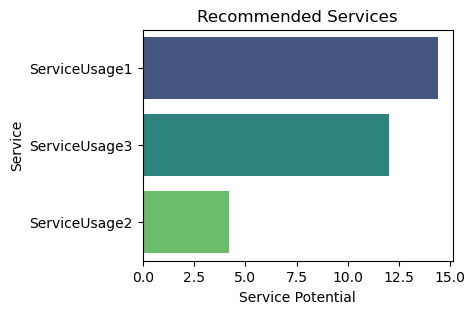

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recommended services
plt.figure(figsize=(4, 3))
sns.barplot(x=recommendations.values, y=recommendations.index, palette='viridis')
plt.title('Recommended Services')
plt.xlabel('Service Potential')
plt.ylabel('Service')
plt.show()

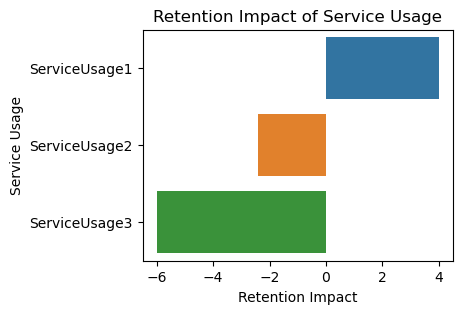

In [122]:
# Plot retention impact
plt.figure(figsize=(4, 3))
sns.barplot(x='retention_impact(%)', y=retention_analysis.index, data=retention_analysis)
plt.title('Retention Impact of Service Usage')
plt.xlabel('Retention Impact')
plt.ylabel('Service Usage')
plt.show()
